Explanatation of machine learning model and data analysis. Walks through data accumulation, data cleaning, data analysis, machine learning and evaluation. 

Start with importing python libraries for the project. Numpy and Pandas are used for data analysis. Matlplotlib and seaborn used for vizualization and scikit-learn used for machine learning. Home sales data was downloaded from red fin. Data is home sales in my area over the last two years. 

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from pandas.plotting import scatter_matrix
from seaborn import regression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge, ElasticNet
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn import ensemble
import pickle

Now we'll import code to combine the CSV files into one large CSV file with all the data combined. 

In [108]:
import os 
import glob
import pandas as pd
# directory to pull files from  
os.chdir("/Users/dannysibley/desktop/Housing_Price_ML")

#credited:
#https://stackoverflow.com/questions/9234560/find-all-csv-files-in-a-directory-using-python/12280052

extension= 'csv'
all_filenames = [i for i in glob.glob('*{}'.format(extension))]

#combine all files in list
combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames])

#export to csv, saved as combined_csv.csv
combined_csv.to_csv('combined_csv.csv', index = False, encoding = 'utf-8-sig')

Convert the csv that was just created into a pandas dataframe. This allows us to utilize pandas features while being stored in a memory efficient format.  

In [109]:
# imports and reads data from csv file
data = pd.read_csv('combined_csv.csv')

Now we'll begin the EDA (exploritory data analysis) phase. This entails gaining insights about the data through data analyis, vizualizations and mathmatical properties. 
I'll walkthrough each step. 

I'll be using a linear regression model for machine learning so we need to drop any data with text. The data from redfin included columns such as address, property type and status that are unneeded. The model will account for location by using zipcodes. 

Pandas loc function allows you to effieciently grab the columns you want based off header name or index location. 

In [201]:
# removes unwanted features
df2 = data.loc[:,('ZIP OR POSTAL CODE', 'BEDS','BATHS', 'SQUARE FEET','LOT SIZE','YEAR BUILT','PRICE',)]


Most programming languages have issues processing spaces. So we'll rename columns to remove spaces. 

In [202]:

# renames columns, in same matrix
df2.rename(columns={'ZIP OR POSTAL CODE': 'ZIPCODE', 'SQUARE FEET': 'SQFT',
           'LOT SIZE': 'LOT_SIZE', 'YEAR BUILT': 'YEAR_BUILT'}, inplace=True)

It's a good idea to look at your data after every manipulation to see the changes made. The describe function is a good way to accomplish this. It displays key metrics such as the number of entries (count), mean, std, etc. 

In [203]:
df2.describe()

,ZIPCODE,BEDS,BATHS,SQFT,LOT_SIZE,YEAR_BUILT,PRICE
count,3381.000000,3364.000000,3365.000000,3367.000000,3.126000e+03,3360.000000,3.374000e+03
mean,97143.853002,3.510702,2.398514,2139.109593,2.270923e+04,1982.878274,5.893214e+05
std,83.989003,0.850148,0.684809,857.020506,1.598857e+05,28.089113,2.500551e+05
min,97003.000000,1.000000,1.000000,404.000000,4.360000e+02,1866.000000,6.120000e+04
25%,97116.000000,3.000000,2.000000,1531.500000,5.227000e+03,1965.000000,4.600000e+05
50%,97124.000000,3.000000,2.500000,1964.000000,7.405000e+03,1987.000000,5.400000e+05
75%,97223.000000,4.000000,2.500000,2573.500000,1.001800e+04,2004.000000,6.500000e+05
max,98664.000000,14.000000,6.000000,10750.000000,4.075909e+06,2021.000000,5.875000e+06


From this we can see a good summary of the data. There are 3381 rows of data. The average home price is $ 589,321, average bedrooms 3.5, average sqft is 2139. The min and max are also good indicators of anamolies in the data that I'll dive into later. 

The machine learning model will have issues with accounting for incomplete data (null values). There are several ways to account for this. 

For ex: if you had a row that was missing the BEDS data you could replace the value with the average number of BEDS from other homes. 

However this makes assumptions about the data and can lead to misleading models as the data is less accurate. I chose to drop the rows with any missing data. This doens't drastically reduce the amount of rows so it's a good choice for my model.

In [204]:
# data cleaning
# remove entry rows that have incomplete data
df3 = df2.dropna()

Visualization is a great way to quickly see outliers in the data that will lower the accuracy of our model. Matplot lib and seaborn will be used to create graphs. The first graph shows a distribution plot of home prices. Visually we can see that it is a gaussian distribution and we should me able to model it effectively. 



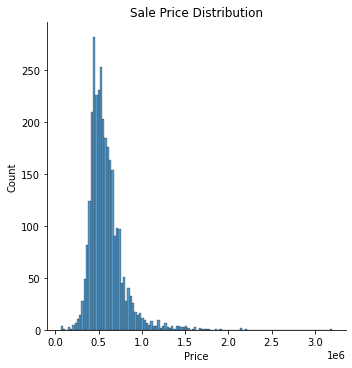

In [179]:
# distribution plot of prices
sns.displot(df3.PRICE)
plt.title('Sale Price Distribution')
plt.xlabel('Price')
plt.show()

The following graph shows the amount of homes that have a particular amount of bedrooms. Our graph shows that most of the homes have 3 bedrooms.

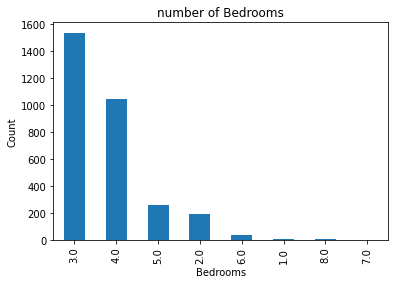

In [180]:
# Bar chart to show number of bedrooms
df3['BEDS'].value_counts(ascending = False).plot(kind='bar')
plt.title('number of Bedrooms')
plt.xlabel('Bedrooms')
plt.ylabel('Count')
plt.show()

Now I'll sort through the data by columns to see the min and max values of each column.

Here you can see a home with 14 bedrooms but only 1705 sqft. This is not likely and the data was most likely entered incorrectly. We'll drop this entry too. 

In [205]:
df3.sort_values(by='BEDS')

,ZIPCODE,BEDS,BATHS,SQFT,LOT_SIZE,YEAR_BUILT,PRICE
1239,97116,1.0,1.0,504.0,49222.0,1920.0,256506.0
2539,97124,1.0,1.0,576.0,6969.0,1947.0,245000.0
474,97206,1.0,1.0,1526.0,13939.0,1935.0,290000.0
896,97116,1.0,1.0,504.0,49222.0,1920.0,256506.0
509,97231,1.0,1.0,1680.0,9583.0,1914.0,424000.0
...,...,...,...,...,...,...,...
1726,97221,8.0,5.0,7962.0,142441.0,1969.0,3650000.0
1276,97116,8.0,4.0,5040.0,12196.0,1912.0,800000.0
806,97116,8.0,4.0,5040.0,12196.0,1912.0,800000.0
1043,97116,10.0,3.0,5736.0,24829.0,1970.0,935000.0


In [206]:
df3 = df3.drop(labels=2481, axis=0)

Now we'll look at the relation between SQFT and Price. A scatter plot is a good choice of graph here to show each entry. We hope to see a linear relationship in the graph. 

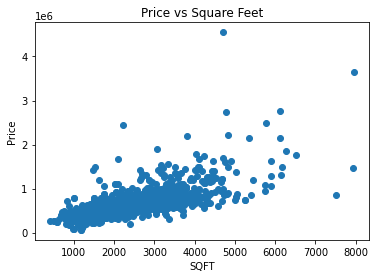

In [215]:
# plots price vs sqft
plt.scatter(df3.SQFT,df3.PRICE)
plt.xlabel("SQFT")
plt.ylabel("Price")
plt.title("Price vs Square Feet")
plt.show()

In [212]:
df3.sort_values(by = 'SQFT')

,ZIPCODE,BEDS,BATHS,SQFT,LOT_SIZE,YEAR_BUILT,PRICE
3282,97123,1.0,1.0,404.0,17424.0,1938.0,260000.0
1239,97116,1.0,1.0,504.0,49222.0,1920.0,256506.0
896,97116,1.0,1.0,504.0,49222.0,1920.0,256506.0
3205,97124,1.0,1.0,576.0,6969.0,1947.0,245000.0
2539,97124,1.0,1.0,576.0,6969.0,1947.0,245000.0
...,...,...,...,...,...,...,...
2050,97221,4.0,4.5,6515.0,65775.0,1939.0,1760000.0
3313,97124,7.0,6.0,7500.0,1742400.0,2021.0,850000.0
2601,97123,5.0,5.0,7929.0,101494.0,1998.0,1474500.0
1726,97221,8.0,5.0,7962.0,142441.0,1969.0,3650000.0


From this we can see 2 homes with more than 9000 sqft. This is very irregular for a home and in a linear regression model this could throw things off so we'll remove the data. 

In [214]:
df3 = df3.drop(labels=[2596, 2152], axis=0)

We'll continue this process with the other columns. 

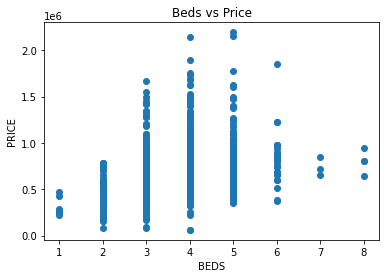

In [184]:
# plots BEDS vs PRICE
plt.scatter(df3.BEDS,df3.PRICE,)
plt.xlabel("BEDS")
plt.ylabel("PRICE")
plt.title("Beds vs Price")
plt.show()

Here we'll sort by price. Looking at the highest value homes you can also see zipcodes that are more typical for higher priced homes. We'll drop some of the homes that are very expensive.

In [216]:
# sorts data by price to view outliers
df3.sort_values(by = 'PRICE')

,ZIPCODE,BEDS,BATHS,SQFT,LOT_SIZE,YEAR_BUILT,PRICE
3189,97124,4.0,1.0,1178.0,5900.0,1930.0,61200.0
2524,97124,4.0,1.0,1178.0,5900.0,1930.0,61200.0
1941,97223,2.0,1.0,1000.0,6534.0,1950.0,86000.0
2179,97007,3.0,2.0,972.0,7841.0,1969.0,86000.0
437,97206,3.0,2.0,1205.0,3709.0,1995.0,95400.0
...,...,...,...,...,...,...,...
415,97219,5.0,4.0,5763.0,53143.0,1940.0,2500000.0
87,97225,4.0,3.5,4776.0,25700.0,1969.0,2730000.0
595,97221,4.0,4.5,6117.0,190357.0,1995.0,2760000.0
1726,97221,8.0,5.0,7962.0,142441.0,1969.0,3650000.0


In [218]:
df3 = df3.drop(labels=[585, 1726, 595, 87, 415, 89, 429, 1043], axis=0)

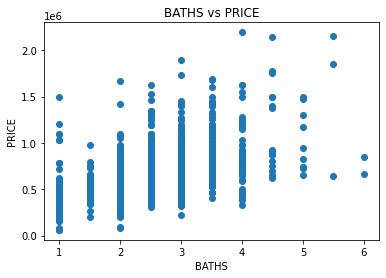

In [219]:
# plots price vs BATHS
plt.scatter(df3.BATHS,df3.PRICE)
plt.xlabel("BATHS")
plt.ylabel("PRICE")
plt.title("BATHS vs PRICE")
plt.show()

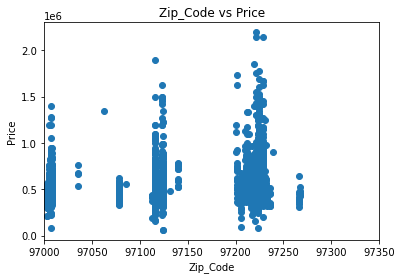

In [220]:
#plot shows zipcode vs price
plt.scatter(df3.ZIPCODE,df3.PRICE)
plt.xlabel("Zip_Code")
plt.ylabel('Price')
plt.title("Zip_Code vs Price")
plt.xlim(97000, 97350)
plt.show()

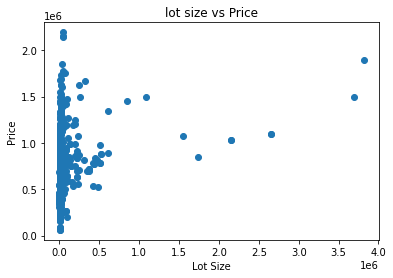

In [221]:
# plots lot size vs price
plt.scatter(df3.LOT_SIZE,df3.PRICE)
plt.xlabel("Lot Size")
plt.ylabel('Price')
plt.title("lot size vs Price")
plt.show()

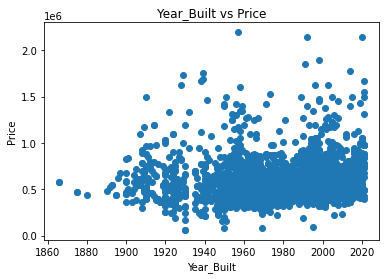

In [222]:
# plots year built vs price
plt.scatter(df3.YEAR_BUILT,df3.PRICE)
plt.xlabel("Year_Built")
plt.ylabel('Price')
plt.title("Year_Built vs Price")
plt.show()

The following graphs show the relationships between all the variables. This gives us a quick over view of all the different combinations of scatter plot graphs we could make with the data. For linear regression we are looking for linear relationships. 

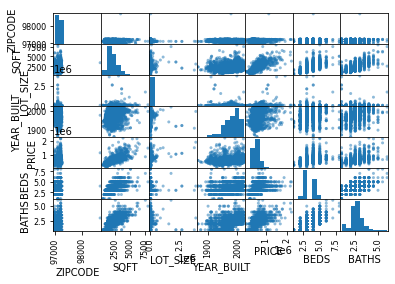

In [190]:
# creates scatter matrix that shows correlations between data
scatter_matrix(df3)
plt.show()

The following graph is a correlation matrix that shows how closely related each feature is. The values closer to 1 indicate that the feautures have a high relation to each other (one effects the other).
From this we can see that sqft has the highest correlation to price at 0.75. 

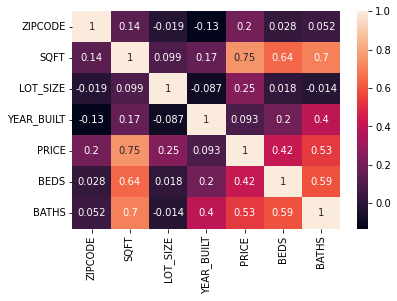

In [191]:
# correlation matrix, numbers closer to 1 indicate more of a correlation
corrMatrix = df3.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

Next we'll being the process of creating the machine learning model. This involves spliting the data in test and train groups. The train data trains the model and the test data tests the model to see if it has learned. 

First we will split our data into two groups. One will have the dependent variable or what we're trying to predict (prices). The other will have the other varibles which we'll call features. 

In [223]:
# store dependent variable seperatly
prices = df3['PRICE']
# remaining variables placed in features
features = df3.drop('PRICE', axis=1)
print(features)

      ZIPCODE  BEDS  BATHS    SQFT  LOT_SIZE  YEAR_BUILT
0       97008   3.0    2.5  2067.0    3484.0      2015.0
1       97008   3.0    2.0  1040.0    8712.0      1979.0
2       97223   4.0    2.5  1997.0    4791.0      1992.0
3       97225   4.0    3.0  3406.0   11325.0      1964.0
4       97225   3.0    2.5  3652.0   21780.0      1959.0
...       ...   ...    ...     ...       ...         ...
3376    97123   5.0    3.0  3980.0   19602.0      1993.0
3377    97123   4.0    2.5  1930.0    9147.0      1978.0
3378    97124   4.0    3.0  1750.0    5663.0      2000.0
3379    97124   4.0    2.5  2156.0    2613.0      2006.0
3380    97124   3.0    3.0  2691.0   32670.0      1973.0

[3081 rows x 6 columns]


In [224]:
# creates instance of Linear regression class
reg = LinearRegression()

# shuffle and split data
X_train, X_test, y_train, y_test = train_test_split(
    features, prices, test_size=0.1, random_state=32)

Now we'll fit the data to our regression model. 

In [225]:
reg.fit(X_train.values, y_train)

LinearRegression()

R^2 is a good metric to evaluate linear regression models. If gives a quantified answer to home accurate the predictions are to the actual data. We'll use scikit-learn's built in r2_score.

In [226]:
# checks score of regression fit
reg_score = reg.score(X_test.values, y_test)
print(f' reg score: {reg_score}')

 reg score: 0.7484881377780337


The model isn't very accurate at 74.8%. We'll introduce gradient boosting to try and get a more accurate model. Gradient boosting takes a combination of more simple models to create an ensemble. The goal is to reduce the prediction error with each successive model.

I played around with the parameters to get a best fit. 

In [227]:
# gradient boosting
clf = ensemble.GradientBoostingRegressor(
    n_estimators=500, max_depth=4, min_samples_split=5, learning_rate=0.1, loss='huber')
clf.fit(X_train.values, y_train.values)

GradientBoostingRegressor(loss='huber', max_depth=4, min_samples_split=5,
                          n_estimators=500)

In [228]:
# checks clf score
clf_score = clf.score(X_test.values, y_test)
print(f'clf score: {clf_score}')

clf score: 0.8223502657083884


The gradient boosted score is much more accurate than the original linear regression model. 

Now we can use our model to actually make predictions by inputting paramters and the model will output a price estimate. 

In [237]:
# ZIPCODE, BEDS, BATHS, SQFT, LOT_SIZE, YEAR_BUILT
Xnew = [[97008, 3, 2.5, 1778, 2600, 2010]]

#makes a prediction
reg_predict = reg.predict(Xnew)

# show the inputs and predicted outputs
print(f'Linear regression model: Zipcode: {Xnew[0][0]}, BEDS: {Xnew[0][1]}, BATHS: {Xnew[0][2]}, SQFT: {Xnew[0][3]}, LOT_SIZE: {Xnew[0][4]}, YEAR_BUILT: {Xnew[0][5]} Predicted home price is: ${reg_predict}')

# makes clf prediction
clf_predict = clf.predict(Xnew)
print(f' Boosted prediction: ${clf_predict}')

Linear regression model: Zipcode: 97008, BEDS: 3, BATHS: 2.5, SQFT: 1778, LOT_SIZE: 2600, YEAR_BUILT: 2010 Predicted home price is: $[497467.08624388]
 Boosted prediction: $[472705.95540584]


Using redfin as a comparison I searched for homes sold in the last 6 months and inputted the parameters into my model. Here's some that I found. 

ZIPCODE: 97007 
BEDS: 3 
BATHS: 2.5 
SQFT: 1900
LOT_SIZE: 2600
YEAR_BUILT: 1997 
Sold PRICE: $507,000
Predicted Price w/ linear Reg: $519040.88
boosted prediction:  $484,116.58

Zipcode: 97007
BEDS: 3
BATHS: 2
SQFT: 1910
LOT_SIZE: 3049
YEAR_BUILT: 2018 
Sold PRICE: $560,000
Predicted Price w/ linear Reg: $507546.54
Boosted prediction: $550225.95

Zipcode: 97008
BEDS: 3
BATHS: 2.5
SQFT: 1778
LOT_SIZE: 2600
YEAR_BUILT: 2010
SOLD Price: $507,000
Predicted Price w/ linear Reg: $497467.08
Boosted prediction: $472705.95


In general both models seem to underestimate the price of homes. Sometimes the boosted model is more accurate, other times the lienar regression model is more accurate. Overall the model gives a rough estimate and the project was a fun and educational experience with data science. 

Here are some ways it could be improved:

1. The model doesn't take into account many other parameters such as when homes were sold to account for inflation over time, this was removed for the sake of simplicity and all home sales were from the previous two years. 

2. The model doesn't take into account exact locations, zipcodes cover a wide area and home prices can drastically vary in a small area. Good neighborhoods and bad neighborhoods can both be within the same zipcode. 

3. The sample size of 3300 entries is small. More data would improve the accuracy of the model. 

4. Using more advanced modeling like deep learning or other machine learning models to improve accuracy. 

When creating a machine learning model you also need to think about the data source and bias's in the data. Your entire model is based on the data so you need to make sure the data is reliable and reasonable. Being knowlegable in the field that your data comes from can help make sense of the data and verify that the outcomes are reasonable. 

Home prices are notoriously subjective. The sale price is what someone will pay for the home, not necessarily what its worth. There is a lot of emotion in home buying and this can't always be quantified into a model. For example someone touring a home could love the kithcen and be willing to outbid any offers to get the home. If a company with the resources like Zillow can't accurately predict home prices with AI it shows the difficulty in modeling the data. 